# Bitcoin price prediction in XGBoost model

This notebook demonstrates how to build and tune a machine learning model using XGBoost to predict Bitcoin closing prices based on historical data and technical indicators.

In [ ]:
#Binance API keys for accessing the API
#Binance API documentation: https://python-binance.readthedocs.io/en/latest/market_data.html
api_key='YOUR_API_KEY'
api_secret='YOUR_API_SECRET'

In [2]:
# Import the Binance client
from binance.client import Client
client = Client(api_key, api_secret)

In [3]:
import pandas as pd
import datetime

# Define the symbol for BTC/USDT pair
symbol = 'BTCUSDT'

# Define custom start and end time
start_time = datetime.datetime(2024, 1, 1, 0, 0, 0)
end_time = datetime.datetime(2025, 5, 31, 23, 59, 59)

klines = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_30MINUTE, start_str=str(start_time), end_str=str(end_time))

# Convert the data into a pandas dataframe for easier manipulation
BTCUSDT = pd.DataFrame(klines, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'])


columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume']

for col in columns_to_convert:
    BTCUSDT[col] = BTCUSDT[col].astype(float)
BTCUSDT['Open Time'] = pd.to_datetime(BTCUSDT['Open Time'], unit='ms')
BTCUSDT['Close Time'] = pd.to_datetime(BTCUSDT['Close Time'], unit='ms')
BTCUSDT

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2024-01-01 00:00:00,42283.58,42554.57,42261.02,42419.73,823.95971,2024-01-01 00:29:59.999,3.496655e+07,29983.0,424.28920,1.800262e+07,0
1,2024-01-01 00:30:00,42419.73,42490.74,42354.19,42475.23,447.72137,2024-01-01 00:59:59.999,1.899070e+07,17151.0,258.28661,1.095480e+07,0
2,2024-01-01 01:00:00,42475.23,42513.17,42431.65,42493.16,341.24790,2024-01-01 01:29:59.999,1.449300e+07,13836.0,195.10908,8.285706e+06,0
3,2024-01-01 01:30:00,42493.16,42775.00,42493.16,42613.56,855.13066,2024-01-01 01:59:59.999,3.649190e+07,36560.0,517.21319,2.206994e+07,0
4,2024-01-01 02:00:00,42613.57,42638.41,42531.10,42546.01,356.59799,2024-01-01 02:29:59.999,1.517873e+07,15307.0,133.15169,5.667197e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
24811,2025-05-31 21:30:00,104786.12,104884.16,104731.70,104863.16,138.54398,2025-05-31 21:59:59.999,1.452293e+07,39597.0,60.92747,6.386736e+06,0
24812,2025-05-31 22:00:00,104863.16,104900.00,104737.83,104737.84,127.95979,2025-05-31 22:29:59.999,1.341411e+07,31426.0,60.63208,6.356461e+06,0
24813,2025-05-31 22:30:00,104737.84,104756.96,104603.08,104625.80,100.14712,2025-05-31 22:59:59.999,1.048308e+07,21366.0,39.49627,4.134257e+06,0
24814,2025-05-31 23:00:00,104625.79,104840.00,104473.20,104646.68,263.82317,2025-05-31 23:29:59.999,2.761744e+07,39598.0,120.95226,1.266103e+07,0


In [4]:
Bitcoin = BTCUSDT[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']]
Bitcoin.dropna(inplace=True)
Bitcoin.tail()

/var/folders/2c/t8gjhcys7qn7kvqjb4v4r9yh0000gn/T/ipykernel_1805/3638627360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bitcoin.dropna(inplace=True)


,Open Time,Open,High,Low,Close,Volume
24811,2025-05-31 21:30:00,104786.12,104884.16,104731.70,104863.16,138.54398
24812,2025-05-31 22:00:00,104863.16,104900.00,104737.83,104737.84,127.95979
24813,2025-05-31 22:30:00,104737.84,104756.96,104603.08,104625.80,100.14712
24814,2025-05-31 23:00:00,104625.79,104840.00,104473.20,104646.68,263.82317
24815,2025-05-31 23:30:00,104646.69,104685.87,104584.99,104591.88,96.93335


In [5]:
Bitcoin['Return_1'] = Bitcoin['Close'].pct_change(1)
Bitcoin['Return_3'] = Bitcoin['Close'].pct_change(3)
Bitcoin['High_Low_Spread'] = Bitcoin['High'] - Bitcoin['Low']
Bitcoin['MA20'] = Bitcoin['Close'].rolling(window=20).mean()
Bitcoin['MA60'] = Bitcoin['Close'].rolling(window=60).mean()
Bitcoin['EMA20'] = Bitcoin['Close'].ewm(span=20, adjust=False).mean()
Bitcoin['EMA60'] = Bitcoin['Close'].ewm(span=60, adjust=False).mean()
Bitcoin['Volatility'] = Bitcoin['Return_1'].rolling(window=7).std()

for lag in range(1, 6):
    Bitcoin[f'Close_Lag{lag}'] = Bitcoin['Close'].shift(lag)

/var/folders/2c/t8gjhcys7qn7kvqjb4v4r9yh0000gn/T/ipykernel_1805/591553739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bitcoin['Return_1'] = Bitcoin['Close'].pct_change(1)
/var/folders/2c/t8gjhcys7qn7kvqjb4v4r9yh0000gn/T/ipykernel_1805/591553739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bitcoin['Return_3'] = Bitcoin['Close'].pct_change(3)
/var/folders/2c/t8gjhcys7qn7kvqjb4v4r9yh0000gn/T/ipykernel_1805/591553739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [6]:
import ta
Bitcoin['RSI'] = ta.momentum.RSIIndicator(close=Bitcoin['Close']).rsi()
Bitcoin['MACD'] = ta.trend.MACD(close=Bitcoin['Close']).macd()
Bitcoin['BB_H'] = ta.volatility.BollingerBands(close=Bitcoin['Close']).bollinger_hband()
Bitcoin['BB_L'] = ta.volatility.BollingerBands(close=Bitcoin['Close']).bollinger_lband()

# Drop missing values created by rolling calculations
Bitcoin.dropna(inplace=True)

In [7]:
Bitcoin.index = Bitcoin['Open Time']
Bitcoin = Bitcoin.drop(columns=['Open Time'])

In [8]:
Bitcoin

,Open,High,Low,Close,Volume,Return_1,Return_3,High_Low_Spread,MA20,MA60,...,Volatility,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,RSI,MACD,BB_H,BB_L
Open Time,,,,,,,,,,,,,,,,,,,,,
2024-01-02 05:30:00,45261.08,45318.44,45133.17,45179.48,666.76283,-0.001803,-0.004030,185.27,44573.3005,43278.359833,...,0.003334,45261.08,45179.80,45362.27,45402.38,45316.71,72.645177,580.741208,46024.961645,43121.639355
2024-01-02 06:00:00,45179.48,45283.44,45130.00,45250.20,596.56532,0.001565,0.001558,153.44,44650.8325,43325.534333,...,0.002244,45179.48,45261.08,45179.80,45362.27,45402.38,73.687074,558.815290,46072.883599,43228.781401
2024-01-02 06:30:00,45250.20,45308.15,45168.74,45168.75,793.77300,-0.001800,-0.002040,139.41,44724.8770,43370.426333,...,0.002280,45250.20,45179.48,45261.08,45179.80,45362.27,70.363014,528.771163,46091.801825,43357.952175
2024-01-02 07:00:00,45168.75,45643.75,45168.74,45461.10,1589.75405,0.006472,0.006233,475.01,44815.1245,43419.892000,...,0.003435,45168.75,45250.20,45179.48,45261.08,45179.80,74.763524,522.527802,46125.038395,43505.210605
2024-01-02 07:30:00,45461.10,45528.00,45278.90,45455.53,1522.77073,-0.000123,0.004538,249.10,44906.9405,43467.258167,...,0.003407,45461.10,45168.75,45250.20,45179.48,45261.08,74.536446,511.237217,46122.726355,43691.154645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31 21:30:00,104786.12,104884.16,104731.70,104863.16,138.54398,0.000735,0.001791,152.46,104487.6885,104123.703667,...,0.000839,104786.12,104781.83,104675.71,104698.02,104693.82,65.609008,214.541974,105055.525271,103919.851729
2025-05-31 22:00:00,104863.16,104900.00,104737.83,104737.84,127.95979,-0.001195,-0.000420,162.17,104535.4300,104124.570167,...,0.001009,104863.16,104786.12,104781.83,104675.71,104698.02,60.501615,207.837974,105011.373686,104059.486314
2025-05-31 22:30:00,104737.84,104756.96,104603.08,104625.80,100.14712,-0.001070,-0.001530,153.88,104565.0220,104136.687667,...,0.000830,104737.84,104863.16,104786.12,104781.83,104675.71,56.283175,191.279366,104982.584644,104147.459356


In [9]:
Bitcoin['Target'] = Bitcoin['Close'].shift(-1)
Bitcoin.dropna(inplace=True)

In [10]:
Bitcoin.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Return_1', 'Return_3',
       'High_Low_Spread', 'MA20', 'MA60', 'EMA20', 'EMA60', 'Volatility',
       'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'Close_Lag5',
       'RSI', 'MACD', 'BB_H', 'BB_L', 'Target'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return_1', 'Return_3', 'High_Low_Spread', 
            'MA20','MA60', 'EMA20', 'EMA60', 'Volatility', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'Close_Lag5',
            'RSI', 'MACD', 'BB_H', 'BB_L']
X = Bitcoin[features]
y = Bitcoin['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

base_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R²: 0.9627271551166853
MAE: 3108055.1107440577
MAE: 1214.7202046521606


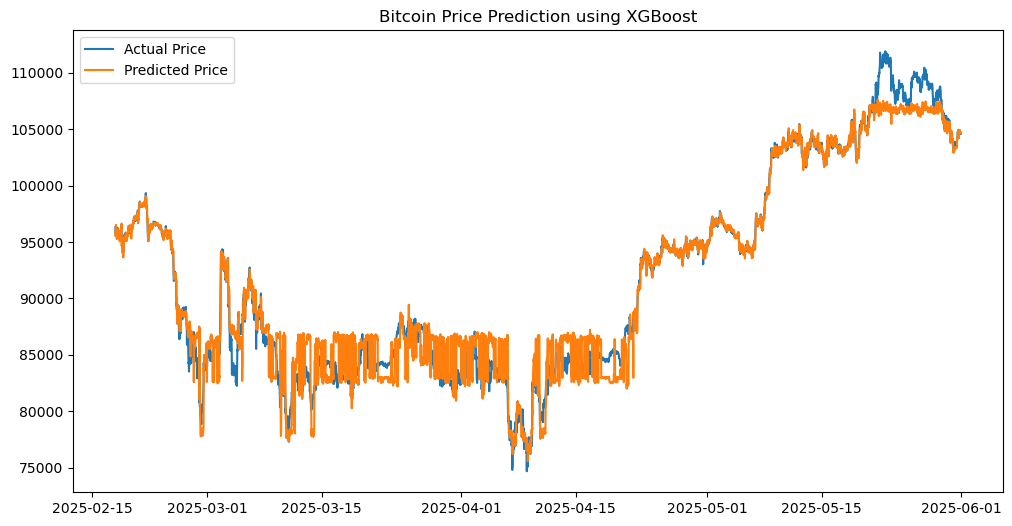

In [15]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price')
plt.title('Bitcoin Price Prediction using XGBoost')
plt.legend()
plt.show()


In [33]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

grid = GridSearchCV(estimator=base_model, param_grid=params, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_params_)


{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.8}


In [34]:
new_model = grid.best_estimator_
y_pred_new = new_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_new)
r2_best = r2_score(y_test, y_pred_new)
mae_best = mean_absolute_error(y_test, y_pred_new)

print("R²:", r2_score(y_test, y_pred_new))
print("MSE:", mean_squared_error(y_test, y_pred_new))
print("MAE:", mean_absolute_error(y_test, y_pred_new))

R²: 0.9725815741973579
MSE: 2286328.792750841
MAE: 1014.0247810228191


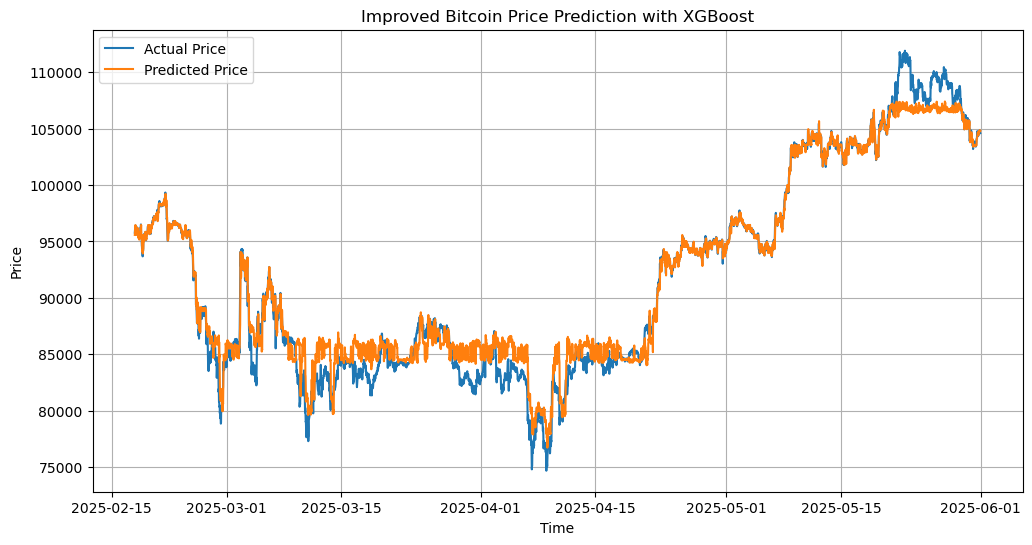

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Price')
plt.plot(y_test.index, y_pred_new, label='Predicted Price')
plt.title('Improved Bitcoin Price Prediction with XGBoost')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Previous model
print("Before tuning:")
print(f"  R²: {r2_score(y_test, y_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"  MSE: {mean_squared_error(y_test, y_pred):.2f}")

# After tuning
print("\nAfter tuning:")
print(f"  R²: {r2_score(y_test, y_pred_new):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_new):.2f}")
print(f"  MSE: {mean_squared_error(y_test, y_pred_new):.2f}")


Before tuning:
  R²: 0.9627
  MAE: 1214.72
  MSE: 3108055.11

After tuning:
  R²: 0.9726
  MAE: 1014.02
  MSE: 2286328.79


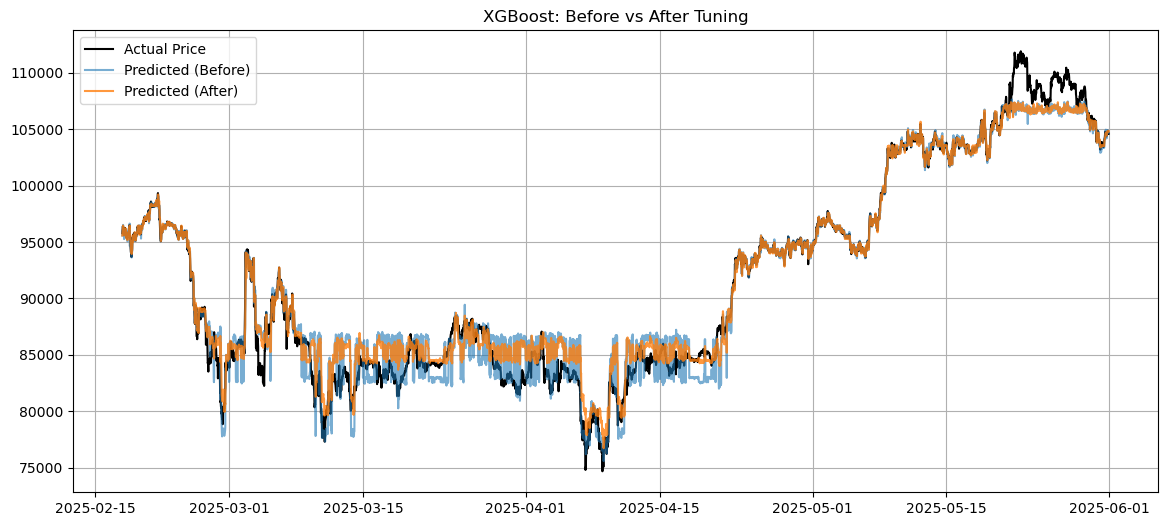

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label='Actual Price', color='black')
plt.plot(y_test.index, y_pred, label='Predicted (Before)', alpha=0.6)
plt.plot(y_test.index, y_pred_new, label='Predicted (After)', alpha=0.8)
plt.title('XGBoost: Before vs After Tuning')
plt.legend()
plt.grid(True)
plt.show()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


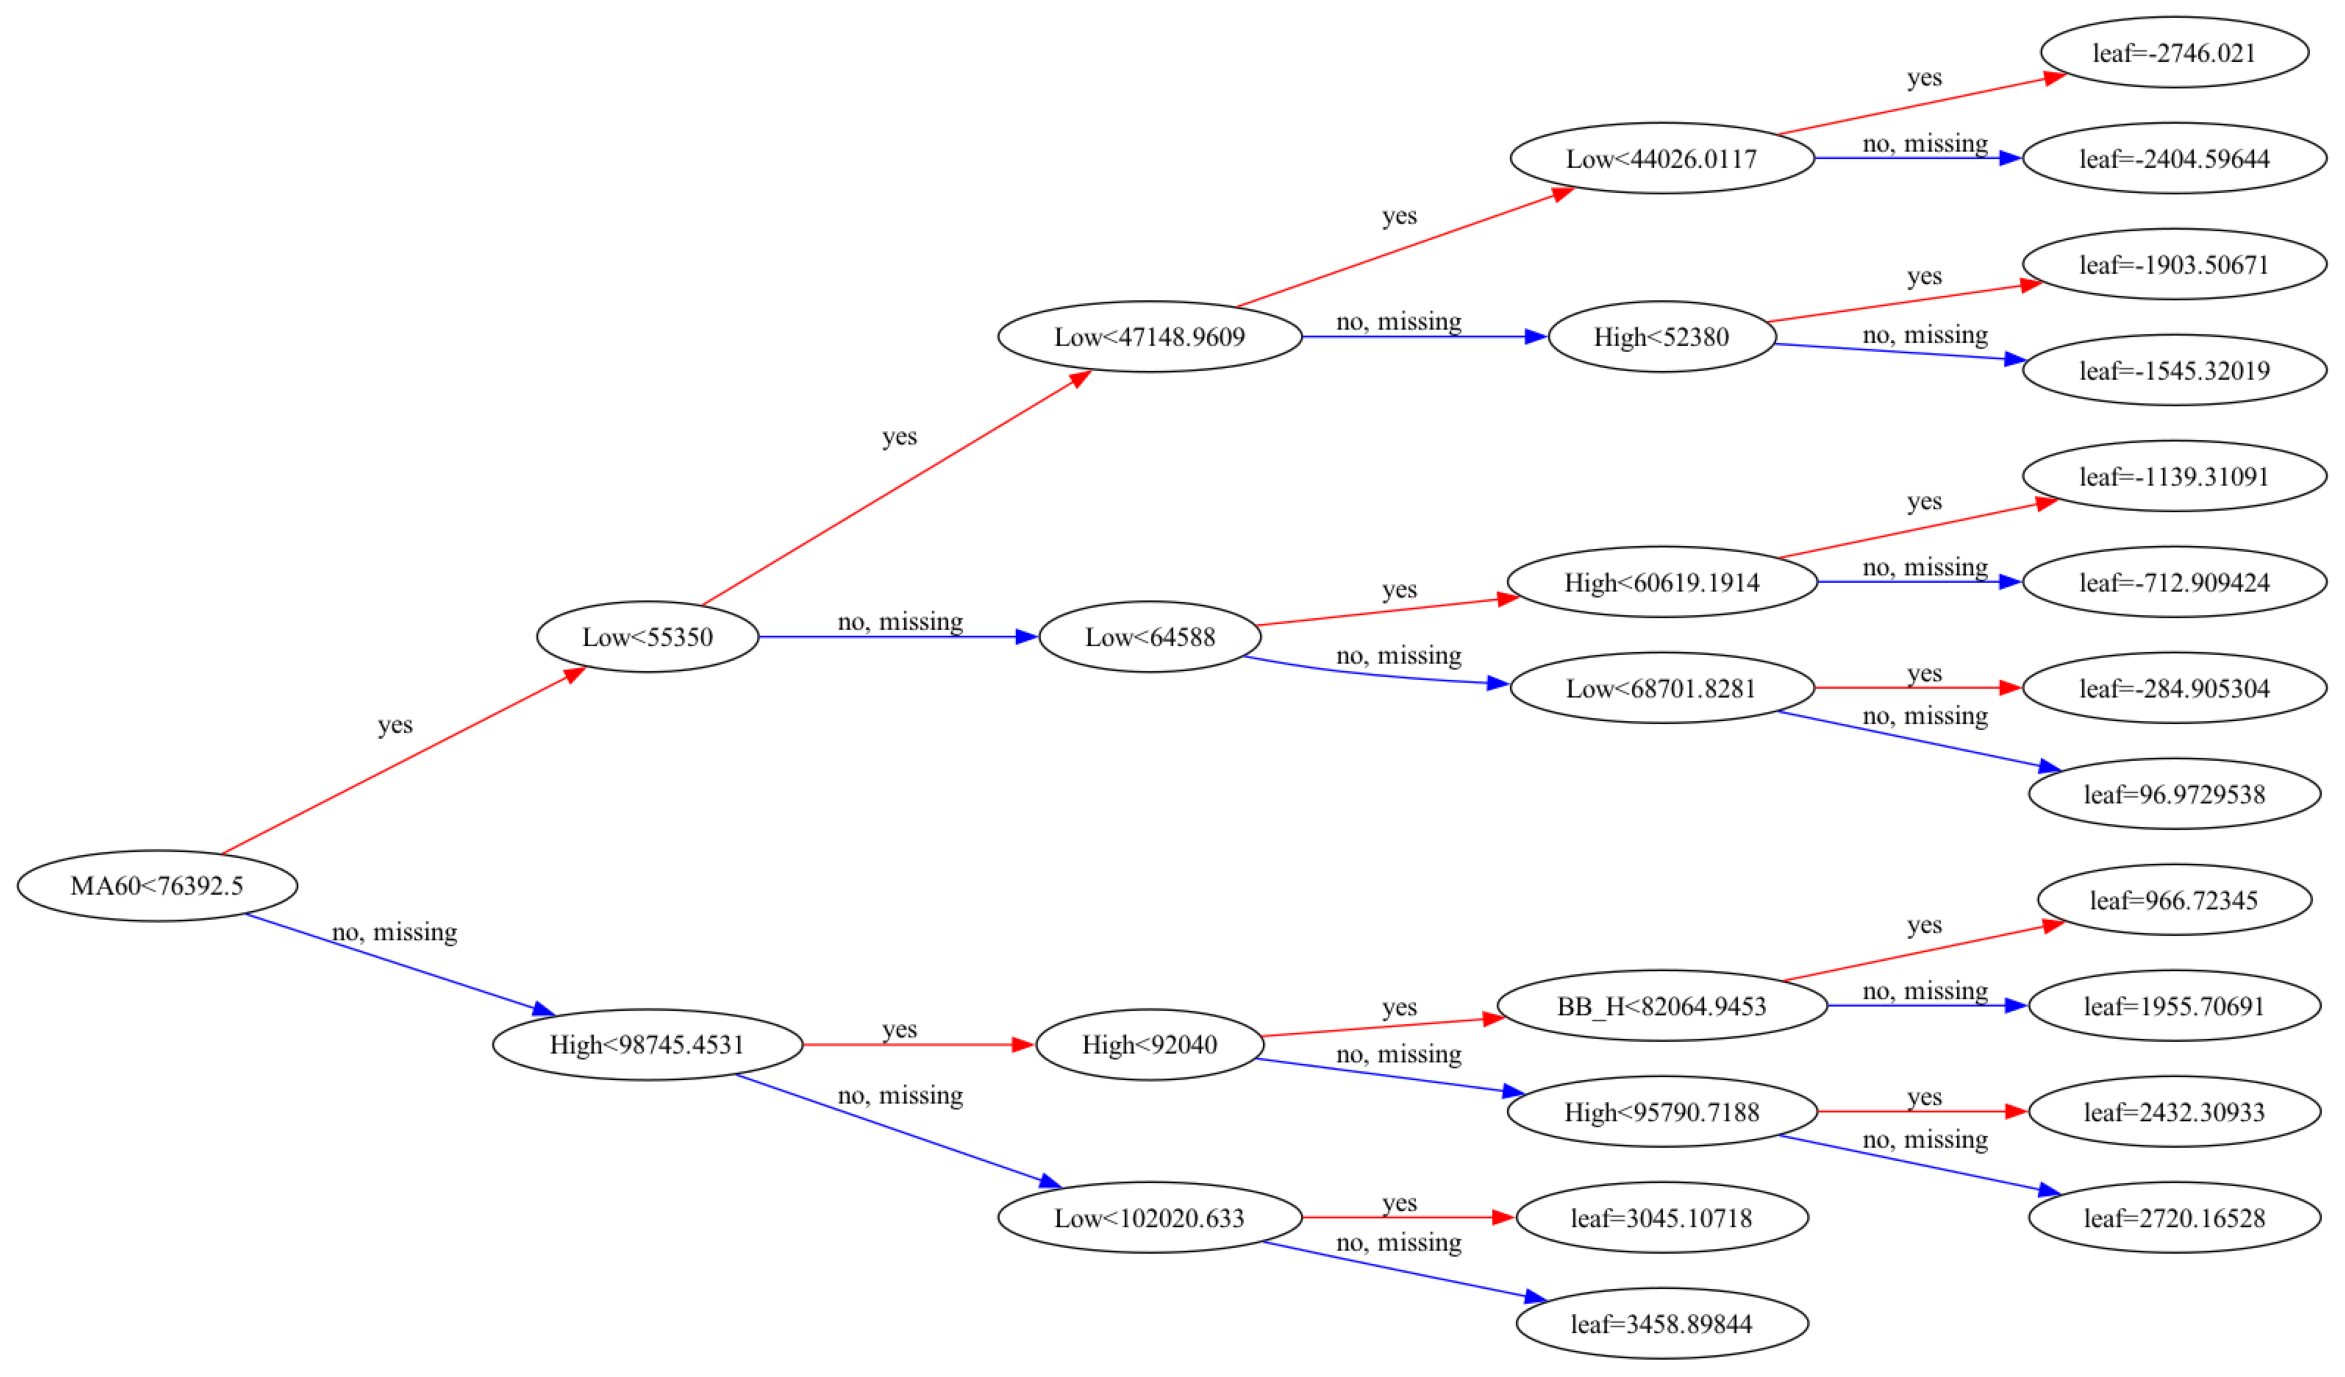

In [38]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
plot_tree(new_model, num_trees=0, rankdir='LR', ax=ax)
plt.savefig('xgb_tree.png', dpi=300, bbox_inches='tight')
plt.show()

